In [2]:
#Import Planning Operator Architectures

from TrainPlanningOperator2D_w_DeepNorm_multgoal import PlanningOperator2D as PlanningOperator2D_w_deepnorm_multgoal
from TrainPlanningOperator2D_w_DeepNorm_singlegoal import PlanningOperator2D as PlanningOperator2D_w_deepnorm_singlegoal
from TrainPlanningOperator2D_wo_DeepNorm_singlegoal import PlanningOperator2D as PlanningOperator2D_wo_deepnorm_singlegoal
from TrainPlanningOperator2D_w_Mahalnobis_multgoal import PlanningOperator2D as PlanningOperator2D_mnorm_multgoal

from TrainPlanningOperator2D_wo_DeepNorm_singlegoal import smooth_chi

from utilities import LpLoss

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary


Load Test Dataset

In [3]:

smooth_coefs = [5.]
smooth_coef = smooth_coefs[0]
# experiments to be replicated with different seeds


################################################################
#                       configs
################################################################
Ntotal = 2000*20+1000*20
ntrain = 2000*20
ntest = Ntotal-ntrain

batch_size = 1


################################################################
# load data and data normalization
################################################################

sub = 1
Sx = int(((15 - 1) / sub) + 1)
Sy = Sx

mask = np.load('./multgoal_dataset/mask.npy')
mask = torch.tensor(mask, dtype=torch.float)
dist_in = np.load('./multgoal_dataset/dist_in.npy')
dist_in = torch.tensor(dist_in[:Ntotal, :, :], dtype=torch.float)
input = smooth_chi(mask, dist_in, smooth_coef)
output = np.load('./multgoal_dataset/output.npy')
output = torch.tensor(output, dtype=torch.float)

goals = np.load('./multgoal_dataset/goals.npy')
goals = torch.tensor(goals, dtype=torch.float)




mask_test = mask[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]
mask_test = mask_test.reshape(ntest, Sx, Sy, 1)
chi_test = input[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]
chi_test = chi_test.reshape(ntest, Sx, Sy, 1)
y_test = output[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]
y_test = y_test.reshape(ntest, Sx, Sy, 1)
goals_test = goals[-ntest:]
goals_test = goals_test.reshape(ntest, 2, 1)

myloss = LpLoss(size_average=False)

test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_test, chi_test, y_test, goals_test),
                                            batch_size=batch_size,
                                            shuffle=True)

Load all Neural Operators Architectures


In [8]:

modes = 8
width = 32
nlayers = 5


model1 = PlanningOperator2D_w_deepnorm_multgoal(modes, modes, width, nlayers)
model1.load_state_dict(torch.load("planningoperator_w_DeepNorm_mulgoal/n40000_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model_depth4.ckpt"))
model1.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)
print("Number of Params - Model 1:",summary(model1, verbose=0).total_params)

model2 = PlanningOperator2D_w_deepnorm_singlegoal(modes, modes, width, nlayers)
model2.load_state_dict(torch.load("planningoperator_w_DeepNorm_singlegoal/n2000_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model_depth4.ckpt"))
model2.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)
print("Number of Params - Model 2:",summary(model2, verbose=0).total_params)

model3 = PlanningOperator2D_wo_deepnorm_singlegoal(modes, modes, width, nlayers)
model3.load_state_dict(torch.load("planningoperator_wo_DeepNorm_singlegoal_increasedparams/n2000_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model_depth4.ckpt"))
model3.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3.to(device)
print("Number of Params - Model 3:",summary(model3, verbose=0).total_params)

model4 = PlanningOperator2D_mnorm_multgoal(modes, modes, width, nlayers)
model4.load_state_dict(torch.load("planningoperator_w_MahalonobisNorm_mulgoal_increasedparams/n40000_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model_depth4.ckpt"))
model4.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4.to(device)
print("Number of Params - Model 4:",summary(model4, verbose=0).total_params)




Number of Params - Model 1: 690304
Number of Params - Model 2: 690304
Number of Params - Model 3: 686849
Number of Params - Model 4: 694528


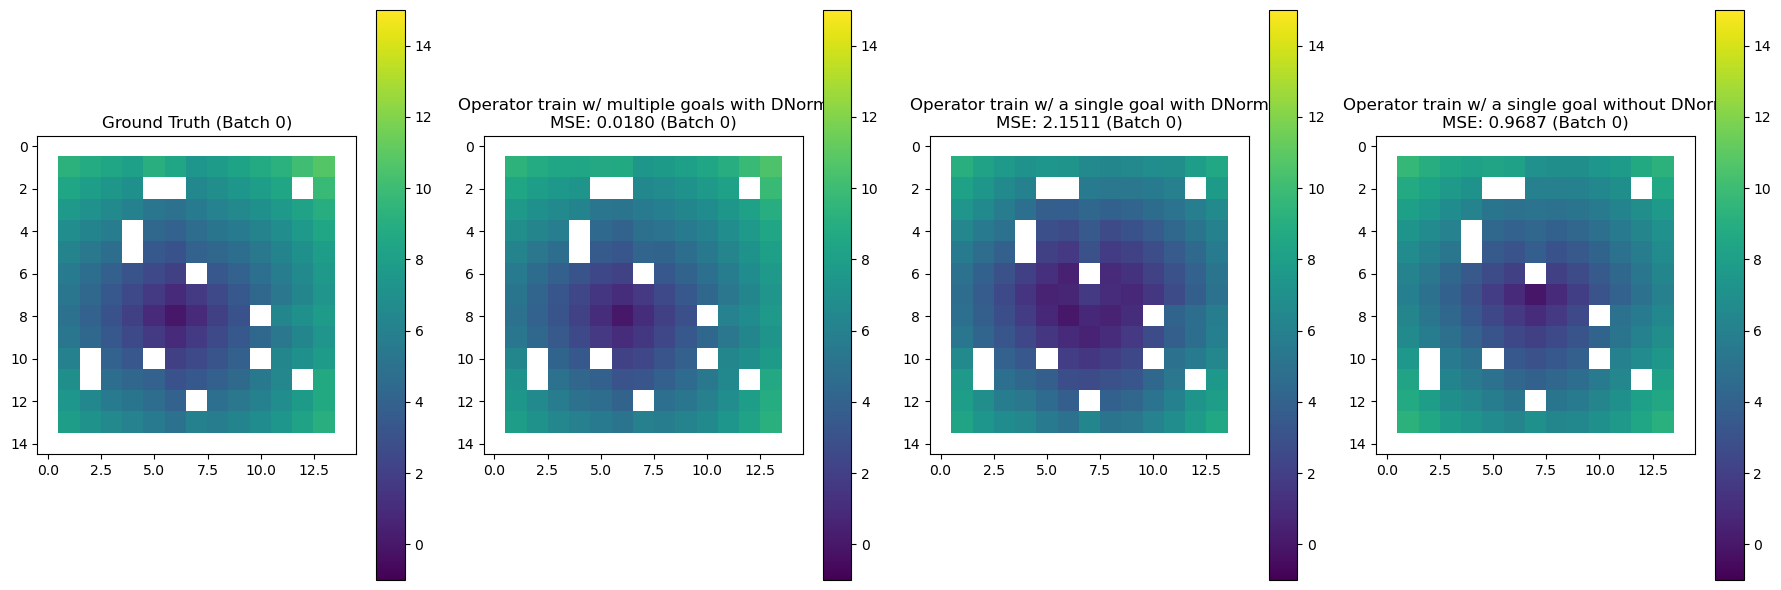

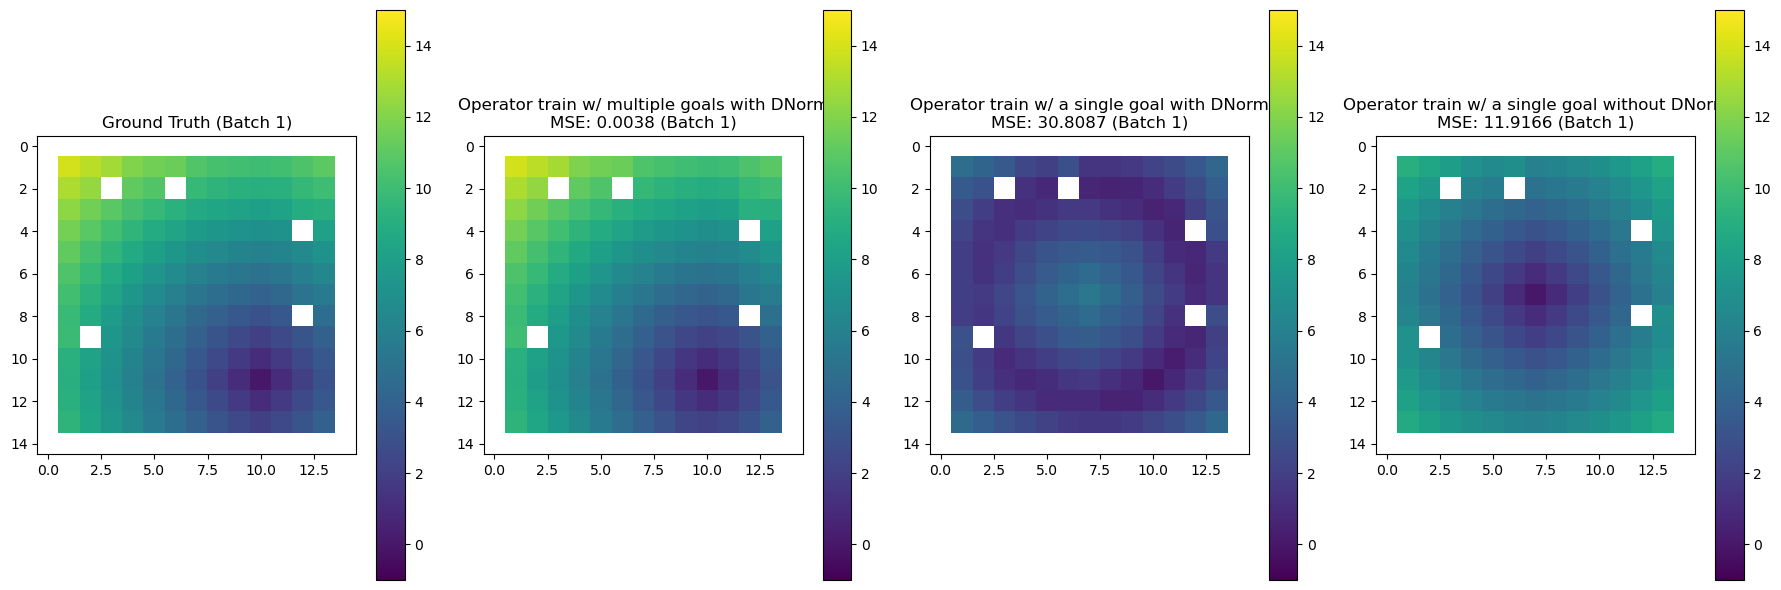

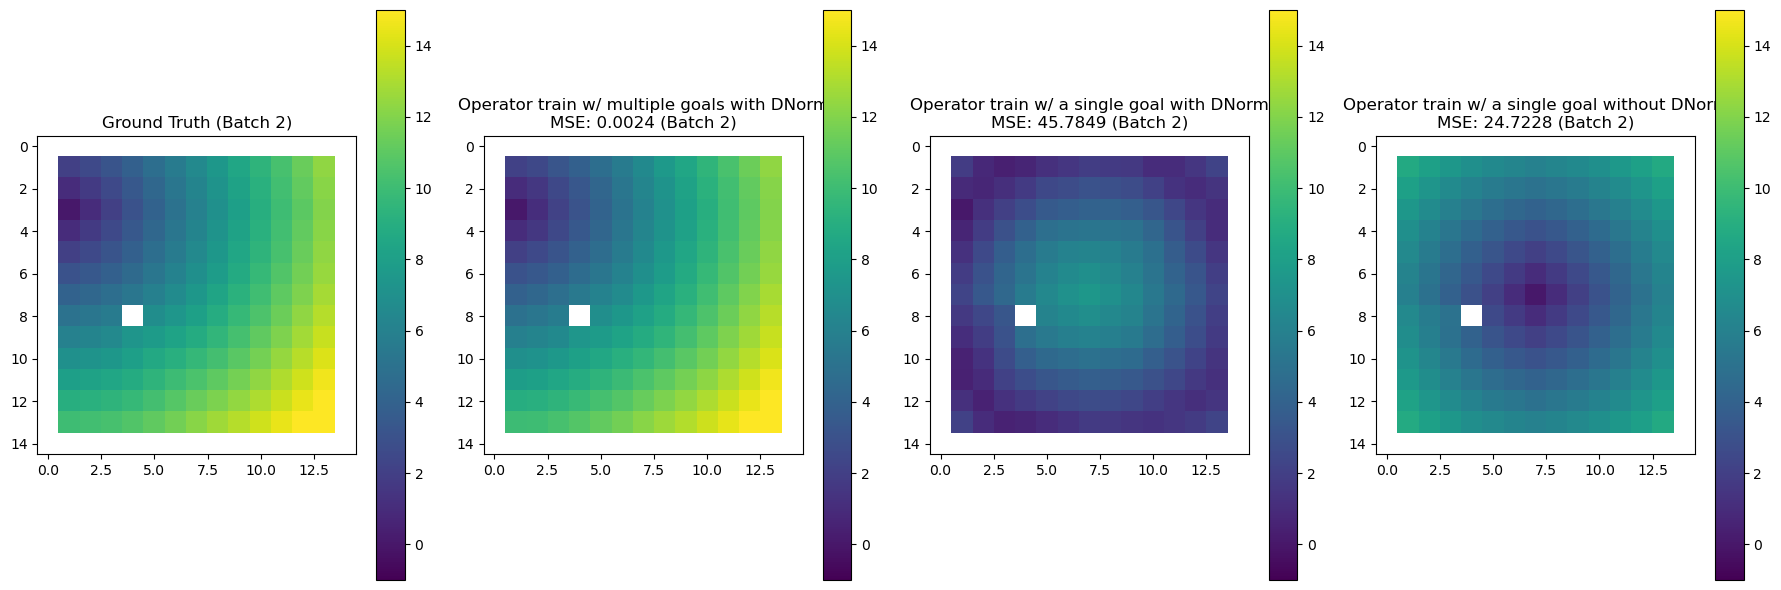

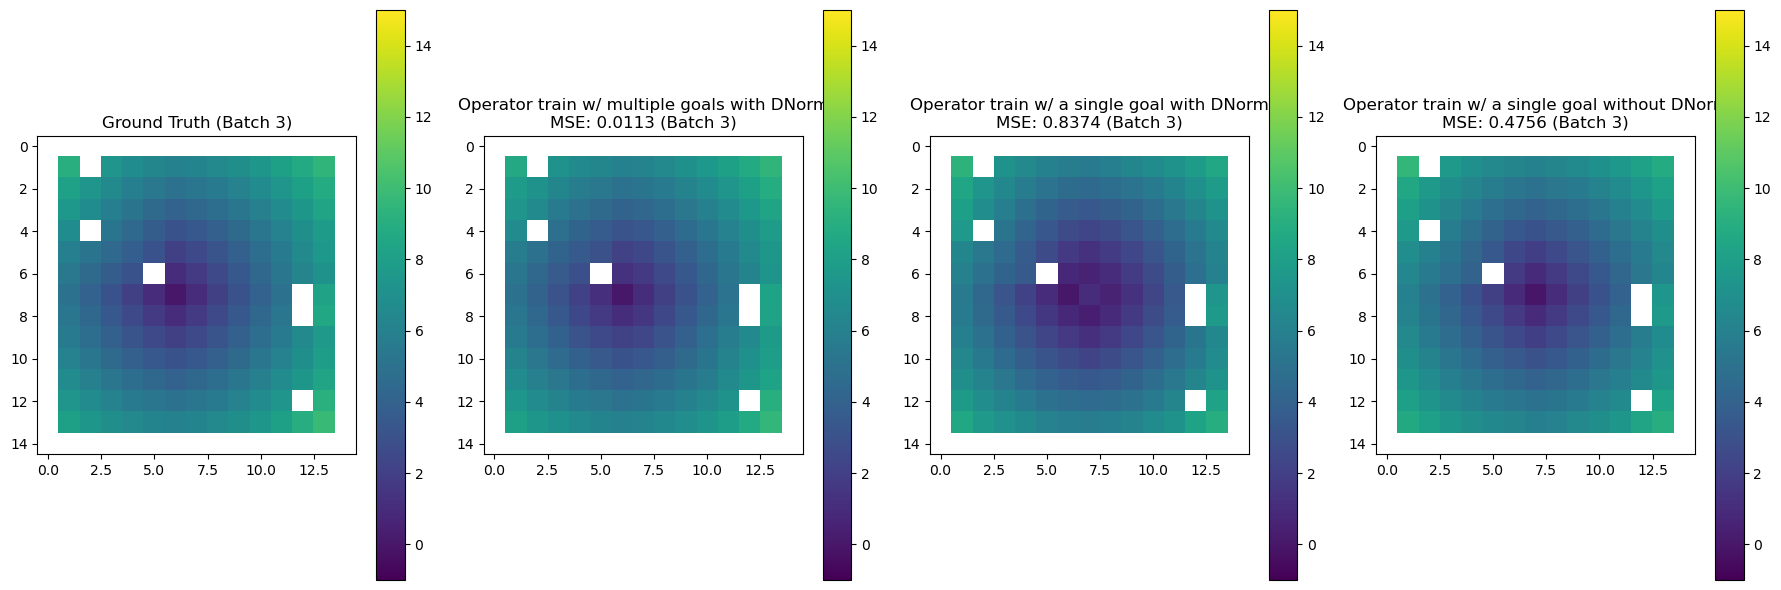

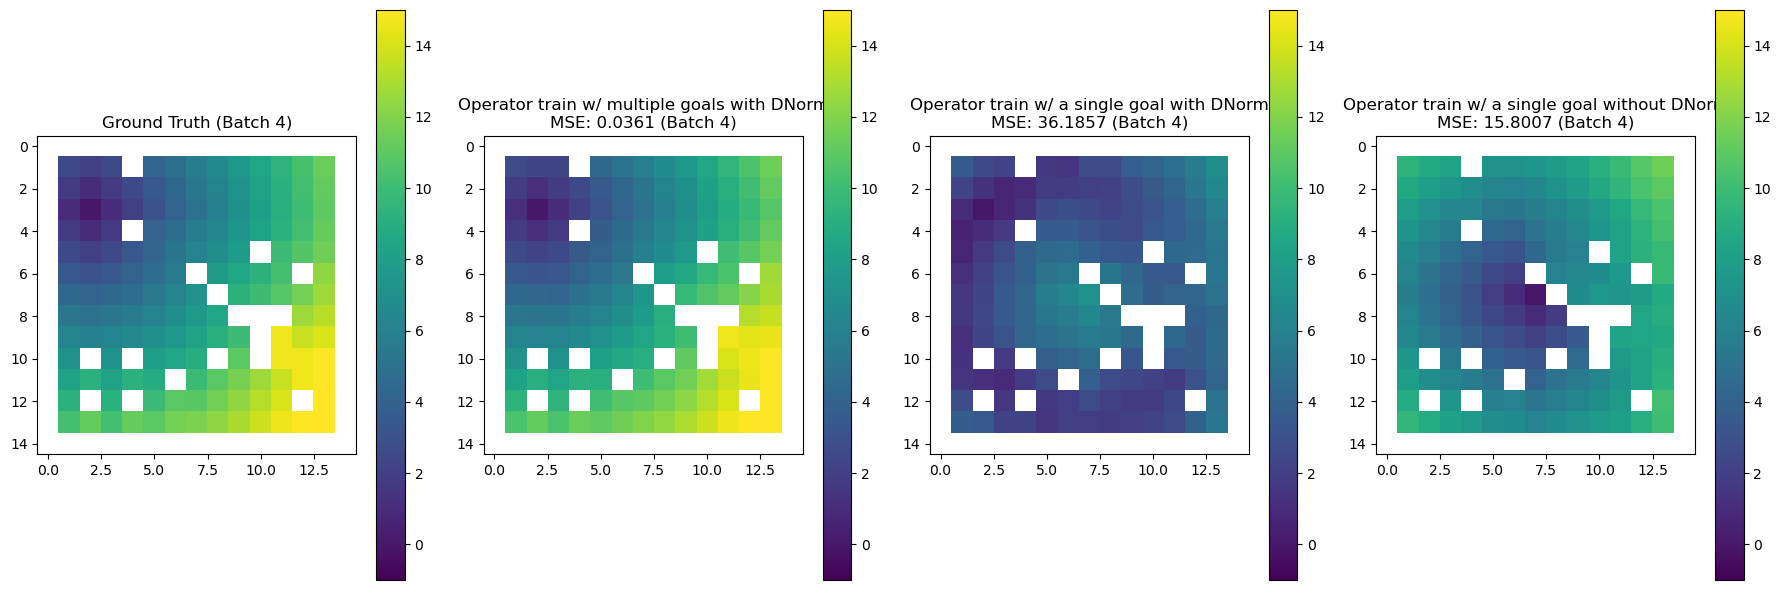

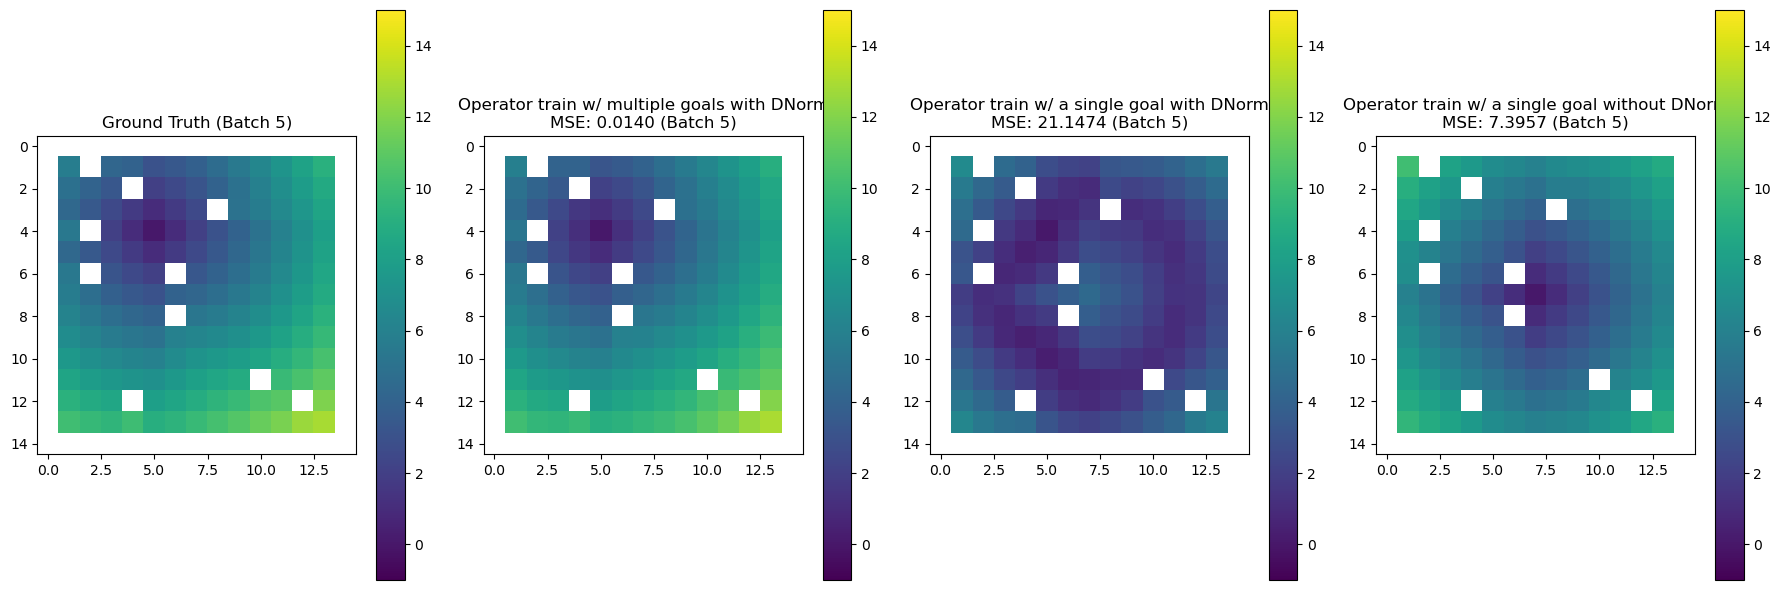

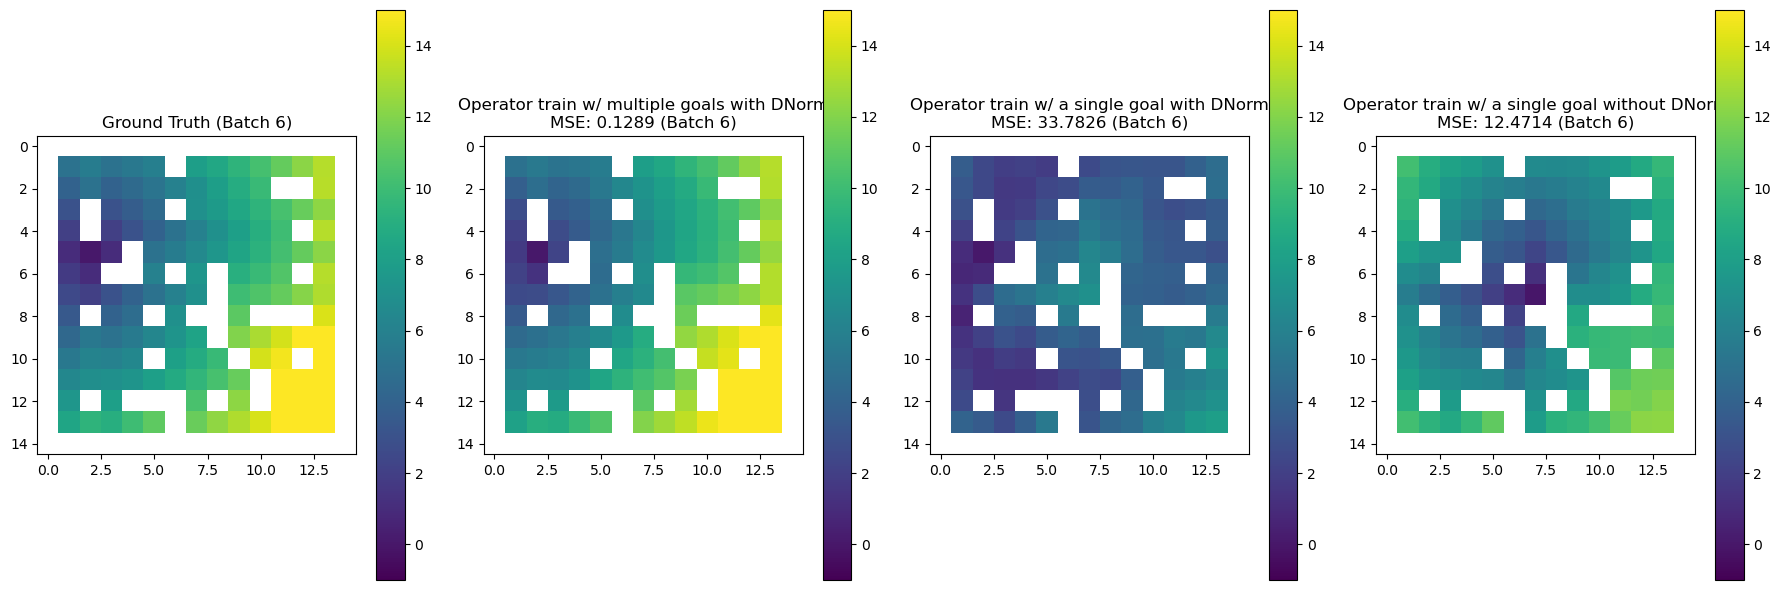

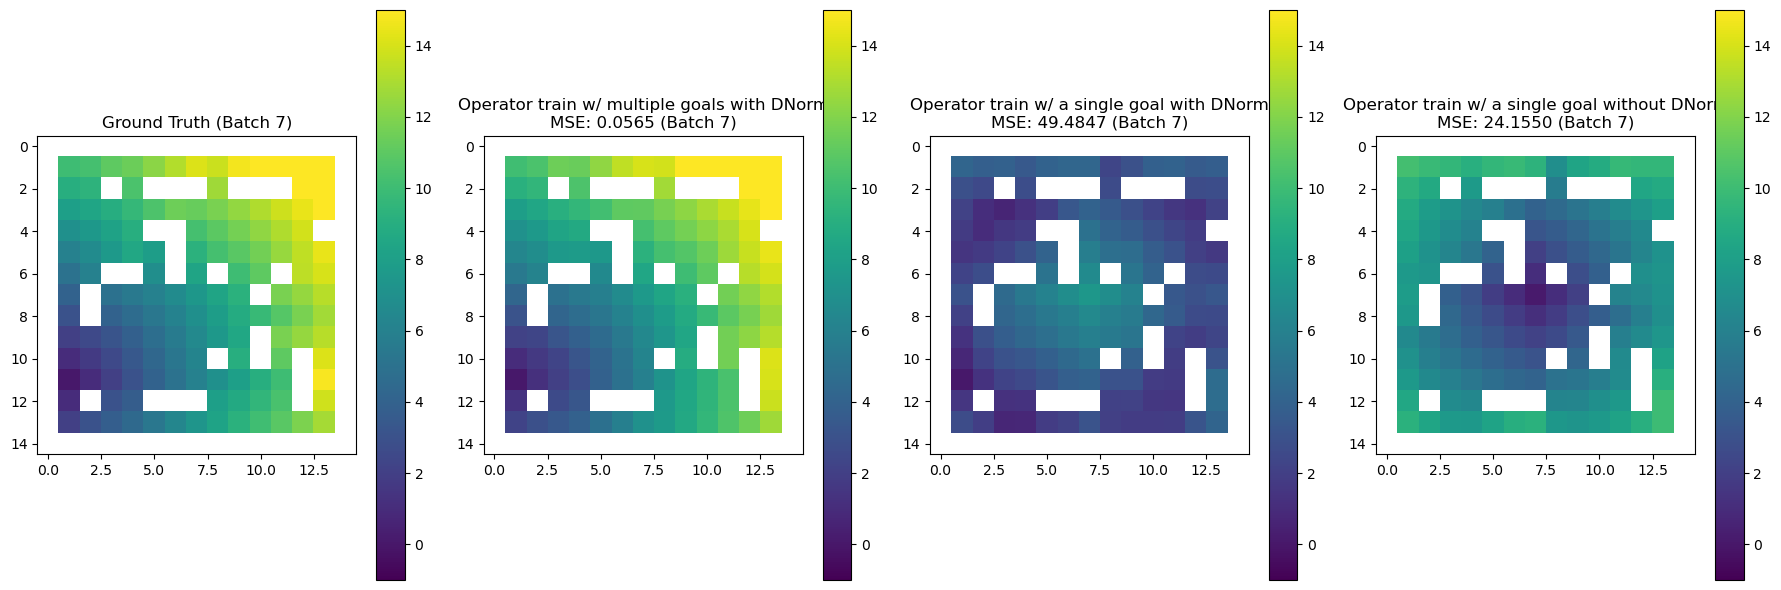

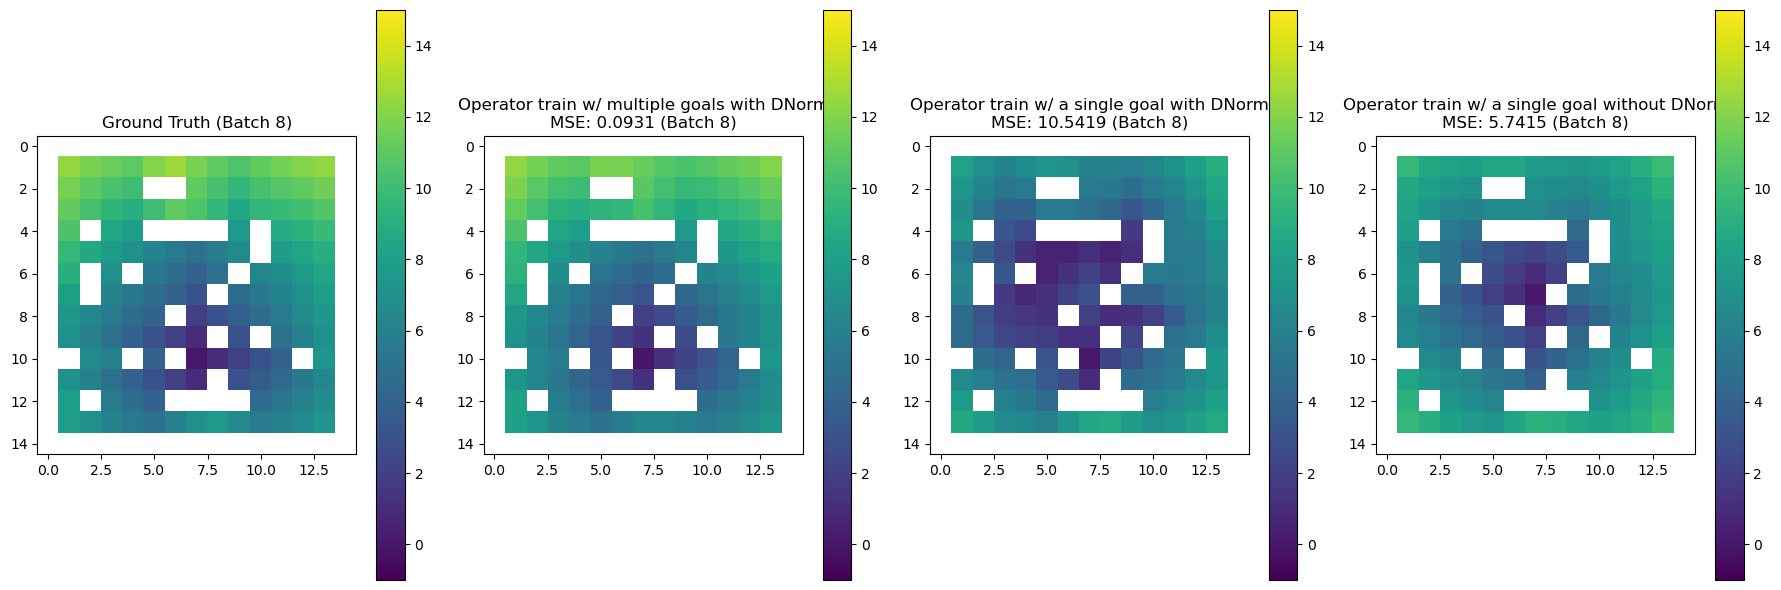

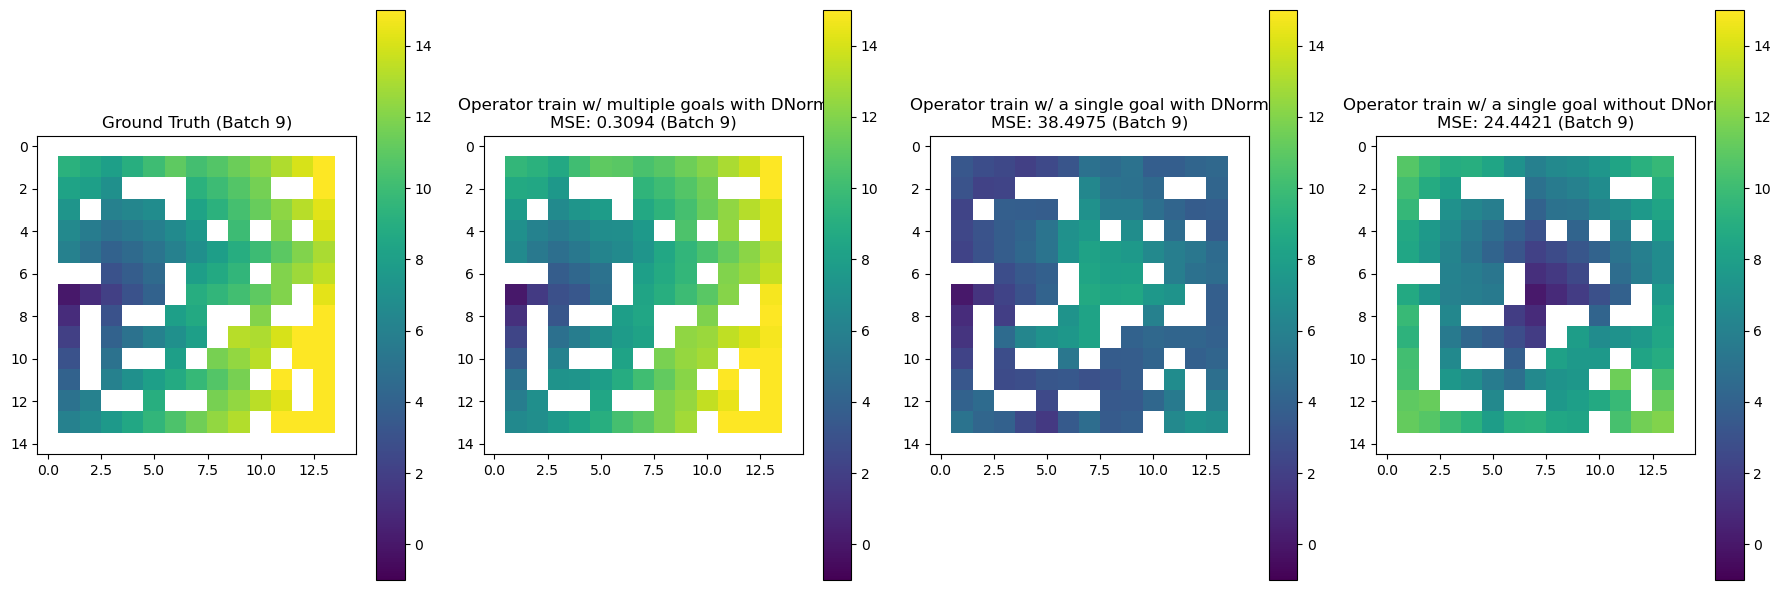

In [6]:
mean_error = 0
count = 0
normalization = 1 / 1.0  # Adjust or calculate as needed

with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device)
        
        predicted_output1 = model1(chi, gg)
        predicted_output2 = model2(chi, gg)
        predicted_output3 = model3(chi, gg)

        predicted_output1 = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output1)
        predicted_output2 = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output2)
        predicted_output3 = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output3)

        ground_truth = torch.where(mask == 0, torch.tensor(float('inf')), ground_truth)

        absolute_error1 = (ground_truth - predicted_output1 * normalization)
        absolute_error2 = (ground_truth - predicted_output2 * normalization)
        absolute_error3 = (ground_truth - predicted_output3 * normalization)

        valid_mask = mask != 0
        batch_count = torch.sum(valid_mask).item()

        # Compute mean squared errors for the current batch
        batch_squared_error1 = torch.sum(absolute_error1[valid_mask] ** 2).item()/batch_count
        batch_squared_error2 = torch.sum(absolute_error2[valid_mask] ** 2).item()/batch_count
        batch_squared_error3 = torch.sum(absolute_error3[valid_mask] ** 2).item()/batch_count

        if batch_id == 10:
            break

        # Plot results for the current batch
        plt.figure(figsize=(18, 6))
        titles = [
            'Ground Truth',
            f'Operator train w/ multiple goals with DNorm\nMSE: {batch_squared_error1:.4f}',
            f'Operator train w/ a single goal with DNorm\nMSE: {batch_squared_error2:.4f}',
            f'Operator train w/ a single goal without DNorm\nMSE: {batch_squared_error3:.4f}'
        ]
        images = [
            ground_truth[0, :, :, 0].cpu().numpy(),
            predicted_output1[0, :, :, 0].cpu().numpy(),
            predicted_output2[0, :, :, 0].cpu().numpy(),
            predicted_output3[0, :, :, 0].cpu().numpy()
        ]

        # Find common vmin and vmax for the absolute error plots
        vmin = min(image.min() for image in images[1:])
        vmax = max(image.max() for image in images[1:])

        for i in range(4):
            plt.subplot(1, 4, i + 1)
            if i == 0:
                plt.imshow(images[i], cmap='viridis', vmin=-1,vmax=15)
            else:
                plt.imshow(images[i], cmap='viridis', vmin=-1,vmax=15)
            plt.title(f'{titles[i]} (Batch {batch_id})')
            plt.colorbar()

        plt.tight_layout()
        plt.show()

In [7]:
batch_size = 30
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_test, chi_test, y_test, goals_test),
                                            batch_size=batch_size,
                                            shuffle=True)

count = 0

out1_test_l2 = 0
out2_test_l2 = 0
out3_test_l2 = 0
out4_test_l2 = 0


with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device)
        
        out1 = model1(chi, gg)
        out1 = out1*mask
        out1_test_l2 += myloss(out1, ground_truth).item()

        out2 = model2(chi,gg)
        out2 = out2*mask
        out2_test_l2 +=myloss(out2, ground_truth).item()

        out3 = model3(chi,gg)
        out3 = out3*mask
        out3_test_l2 +=myloss(out3, ground_truth).item()

        out4 = model4(chi,gg)
        out4 = out4*mask
        out4_test_l2 +=myloss(out4, ground_truth).item()

        count += 1


# Compute overall RMS errors
error1 = (out1_test_l2 / (count*batch_size))
error2 = (out2_test_l2 / (count*batch_size)) 
error3 = (out3_test_l2 / (count*batch_size)) 
error4 = (out4_test_l2 / (count*batch_size)) 


print(f'Error with DeepNorm(Multiple Goals): {error1:.4f}')
print(f'Error with MahalnobisNorm(Multiple Goal): {error4:.4f}')
print(f'Error with DeepNorm(Single Goal): {error2:.4f}')
print(f'Error without DeepNorm(vanilla): {error3:.4f}')





Error with DeepNorm(Multiple Goals): 0.0907
Error with MahalnobisNorm(Multiple Goal): 0.1018
Error with DeepNorm(Single Goal): 0.6005
Error without DeepNorm(vanilla): 0.4651
